<a href="https://colab.research.google.com/github/djvaroli/samsung_oct/blob/Janhavi-Colab-Notebooks/JG_OCT_PretrainedSimCLR_Full_Train_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''%cp drive/MyDrive/OCT_Project/ZhangLabData.zip .
!unzip ZhangLabData.zip'''

# Reference code:
 https://github.com/anoopsanka/retinal_oct/blob/main/notebooks/03c-OCT_PretrainedSimCLR.ipynb

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Samsung-OCT-Project-Work/')
pwd = os.getcwd()
print(pwd)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Samsung-OCT-Project-Work


In [3]:
!ls


ahDdMcSIdcyTfoy		       samsung-oct-super-model-v0.ipynb
HAsIhWpGWVbMVLA		       samsung-oct-super-model-v3.ipynb
HBMEINbkLGPLhEn		       samsung-oct-super-model-v4.ipynb
JG_OCT_PretrainedSimCLR.ipynb  simclrv2_test_plot.png
KuoJPrsqtxHXGny		       StLmmsAPKRAfQyU
MyResNet50		       VGG19_rev0.h5
processed_data		       VGG19-samsung-oct-super-model-v4.ipynb
processed_data.zip_.gstmp      VGG_results.csv
resnet50-img-aug	       VGG_results_load_model.csv
resnet50_model_plot.png        VGG_results_load_model.gsheet
samsung_oct		       wandb


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
seed = 42
val_split   = 0.02
train_split = 1 - val_split
batch_size = 32
IMG_SIZE=224

In [6]:


ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    './processed_data/data/train',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    validation_split=val_split,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    )
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    './processed_data/data/train',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    validation_split=val_split,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    )

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    'processed_data/data/test',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    interpolation="bilinear",
    follow_links=False,
    )

Found 46279 files belonging to 4 classes.
Using 925 files for validation.
Found 83484 files belonging to 4 classes.
Using 81815 files for training.
Found 968 files belonging to 4 classes.


# Feature Extraction with Pretrained SimCLR
- Ultimately we want to train a SimCLR model with the wealth of OCT images
- as a zeroth step, we ask how well are SimCLR pretrained on ImageNet works on the unseen OCT images domain.
- we use SimCLR as a feature extractor and try to see how well a simple linear classification head (multi-class logistic regression) works in terms of distinguiishing between classes


In [7]:
#@title Load module and construct the computation graph
import tensorflow_hub as hub
import tensorflow as tf
# Load the base network and set it to non-trainable (for speedup fine-tuning)
hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'

In [8]:
input_layer  = tf.keras.layers.Input((224,224,3))
simclr_layer = hub.KerasLayer(hub_path, trainable=False,)
classification_head = tf.keras.layers.Dense(4, activation='softmax')


model = tf.keras.Sequential([input_layer, 
                             simclr_layer,
                             classification_head])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              34277672  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 34,285,868
Trainable params: 8,196
Non-trainable params: 34,277,672
_________________________________________________________________


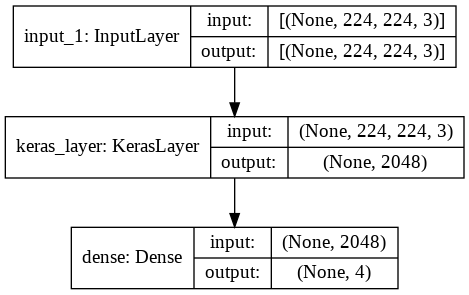

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='simclrv2_test_plot.png',show_shapes=True, show_layer_names=True)

In [11]:
metrics = ['accuracy']
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', ),
             tf.keras.callbacks.ModelCheckpoint(filepath='resnet_model.{epoch:02d}-{val_loss:.2f}.h5'),]
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=metrics)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
import os

# simple version for working with CWD
nCNV = len([name for name in os.listdir('./processed_data/data/train/0')])
nDME = len([name for name in os.listdir('./processed_data/data/train/1')])
nDRUSEN = len([name for name in os.listdir('./processed_data/data/train/2')])
nNORMAL = len([name for name in os.listdir('./processed_data/data/train/3')])

ncount = np.array([nCNV, nDME, nDRUSEN, nNORMAL])
ntotal = sum(ncount)

weights = ntotal/ncount/ len(ncount)
weights /= weights.min()
class_weight = {i: w for i, w in enumerate(weights)}

In [13]:
print(nCNV, nDME, nDRUSEN, nNORMAL)

37205 11348 8616 26315


In [14]:
print(ncount)

[37205 11348  8616 26315]


In [15]:
print(ntotal)

83484


In [16]:
print(weights)

[1.         3.27855129 4.31812906 1.41383241]


# Retrieve the Representation
- we run our examples through the SimCLR to retrieve the embedding as seen by the nerual network


In [17]:
def get_representation(dataset, max_batch=500):
  out_rep, out_label = [], []
  count = 0
  for img, lb in dataset:
    out_rep.append(simclr_layer(img).numpy())
    out_label.append(lb.numpy())
    if count % 100 == 0: print(f'count = {count}')
    if count > max_batch: break
    count += 1
  out_label = np.hstack(out_label)
  out_rep   = np.vstack(out_rep)
  return out_rep, out_label

In [18]:
# train_rep, train_lb = get_representation(ds_train)
test_rep,  test_lb = get_representation(ds_test)

count = 0


In [19]:
train_rep, train_lb = get_representation(ds_train)

count = 0
count = 100
count = 200
count = 300
count = 400
count = 500


In [20]:
train_rep = train_rep / np.sqrt(np.square(train_rep).mean(axis=-1, keepdims=True))
test_rep  = test_rep  / np.sqrt(np.square(test_rep).mean(axis=-1, keepdims=True))

In [21]:
train_rep.shape

(16064, 2048)

In [23]:
import os

# simple version for working with CWD
nCNV = len([name for name in os.listdir('./processed_data/data/train/0')])
nDME = len([name for name in os.listdir('./processed_data/data/train/1')])
nDRUSEN = len([name for name in os.listdir('./processed_data/data/train/2')])
nNORMAL = len([name for name in os.listdir('./processed_data/data/train/3')])

ncount = np.array([nCNV, nDME, nDRUSEN, nNORMAL])
ntotal = sum(ncount)

weights = ntotal/ncount/ len(ncount)
weights /= weights.min()
class_weight = {i: w for i, w in enumerate(weights)}

# Fitting a Linear Regression Model
- attach a dense layer with 4 outputs with softmax activation
- minimize the cross-entropy taking into the account of the inherent imbalance between the 4 classes

In [24]:
learning_rate = 1.0e-3


linearRegression = tf.keras.Sequential([tf.keras.layers.Input(2048),
                                       tf.keras.layers.Dense(4, activation='softmax')])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
linearRegression.compile(loss='sparse_categorical_crossentropy', 
                         metrics='accuracy', 
                         optimizer=optimizer)

In [25]:
history = linearRegression.fit(train_rep, 
                              train_lb, 
                              batch_size=32, 
                              epochs=100,
                              class_weight=class_weight,
                              validation_data=(test_rep, test_lb),)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
502/502 [==============================] - 2s 2ms/step - loss: 2.3786 - accuracy: 0.3940 - val_loss: 1.1852 - val_accuracy: 0.4587
Epoch 2/100
502/502 [==============================] - 1s 2ms/step - loss: 2.1947 - accuracy: 0.4836 - val_loss: 1.0455 - val_accuracy: 0.6333
Epoch 3/100
502/502 [==============================] - 1s 2ms/step - loss: 2.0972 - accuracy: 0.5215 - val_loss: 1.0288 - val_accuracy: 0.6012
Epoch 4/100
502/502 [==============================] - 1s 2ms/step - loss: 2.0337 - accuracy: 0.5480 - val_loss: 0.9750 - val_accuracy: 0.6209
Epoch 5/100
502/502 [==============================] - 1s 2ms/step - loss: 1.9757 - accuracy: 0.5616 - val_loss: 0.9463 - val_accuracy: 0.6322
Epoch 6/100
502/502 [==============================] - 1s 2ms/step - loss: 1.9400 - accuracy: 0.5762 - val_loss: 0.9113 - val_accuracy: 0.6601
Epoc

In [26]:
history = linearRegression.fit(train_rep, 
                               train_lb, 
                               batch_size=32, 
                               epochs=400,
                               class_weight=class_weight,
                               validation_data=(test_rep, test_lb),
                               initial_epoch=200)

Epoch 201/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4278 - accuracy: 0.7046 - val_loss: 0.6337 - val_accuracy: 0.7541
Epoch 202/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4400 - accuracy: 0.7043 - val_loss: 0.6304 - val_accuracy: 0.7552
Epoch 203/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4305 - accuracy: 0.6990 - val_loss: 0.6133 - val_accuracy: 0.7624
Epoch 204/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4295 - accuracy: 0.7000 - val_loss: 0.6073 - val_accuracy: 0.7696
Epoch 205/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4275 - accuracy: 0.7052 - val_loss: 0.6111 - val_accuracy: 0.7603
Epoch 206/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4247 - accuracy: 0.7022 - val_loss: 0.5776 - val_accuracy: 0.7924
Epoch 207/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4240 - accuracy: 0.7041 - val_loss: 0.5832 - val_ac

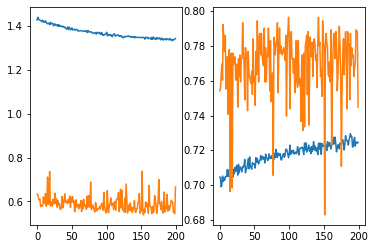

In [27]:
f = plt.figure()
ax1 = f.add_subplot(1,2,1)
ax1.plot(linearRegression.history.history['loss'])
ax1.plot(linearRegression.history.history['val_loss'])

ax2 = f.add_subplot(1,2,2)
ax2.plot(linearRegression.history.history['accuracy'])
ax2.plot(linearRegression.history.history['val_accuracy'])

In [28]:
ypred_train = linearRegression(train_rep).numpy().argmax(axis=-1)
ypred_test  = linearRegression(test_rep).numpy().argmax(axis=-1)

In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(train_lb, ypred_train))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7157
           1       0.63      0.70      0.66      2189
           2       0.56      0.29      0.39      1624
           3       0.77      0.84      0.80      5094

    accuracy                           0.78     16064
   macro avg       0.71      0.68      0.68     16064
weighted avg       0.78      0.78      0.77     16064



In [31]:
print(classification_report(test_lb, ypred_test))

              precision    recall  f1-score   support

           0       0.73      0.95      0.83       242
           1       0.82      0.79      0.81       242
           2       0.89      0.31      0.46       242
           3       0.67      0.94      0.78       242

    accuracy                           0.74       968
   macro avg       0.78      0.74      0.72       968
weighted avg       0.78      0.74      0.72       968

